# Can ICNNs fit arbitrary functions on the sphere?
In this notebook, we train an ICNN and MLP to fit data $\{x_i, y_i\}$ where each of the $x_i$ have unit norm. The networks have the following architectures:

**ICNN**:
$$\begin{align} \phi_i & = \langle A, x_i \rangle + \frac{1}{\sqrt{m}} \sum_{r=1}^m \left( \sigma(w_r^T x_i) - \frac{1}{\sqrt{2\pi}} \right) \qquad \sigma(x) = \max(0, x) \end{align}$$
where $x_i \in \mathbb{R}^2$, $A \in \mathbb{R}^2$, and $w_r \in \mathbb{R}^2$, and the weights are initialized with unit Gaussians. *Both parameters $A$ and the $w_r$ are optimized during training*.

**MLP**:
$$\begin{align} \mu_i & = \frac{1}{\sqrt{m}} \sum_{r=1}^m a_r \sigma(w_r^T x_i) \qquad \sigma(x) = \max(0, x) \end{align}$$
where $x_i \in \mathbb{R}^2$, $a_r \in \mathbb{R}$, and $w_r \in \mathbb{R}^2$, and the weights are initialized with unit Gaussians. *Both parameters $a_r$ and the $w_r$ are optimized during training.*

**Training method**: the ICNN parameters are trained to minimize the objective:

$$\begin{align} \min_{A, \ w_r} \|\phi - y\|_2^2 \end{align}$$

using Adam for 1000 iterations with learning rate 0.001, $\beta_1=0.9$, and $\beta_2 = 0.9$. These values were not optimized for performance in any quantitative way. The MLP parameters are trained with the same objective and hyperparameters.

**How to read this**: each section of the document compares an MLP to an ICNN when fitting a specific dataset. From left to right, each panel shows
1. *Dataset*: values of the function $f : x \to y$ over the entire plane. Each of the red dots is a data point $x_i$ which is assigned $y_i = f(x_i)$.  
2. *Random net output*: output values of the randomly initialized network for each input point in the plane.
3. *Trained net output*: output values of the trained network for each input point in the plane.
4. *Training loss*: a plot of training loss at each gradient descent iteration.

below each panel is a table of ground truth $y_i$ next to the associated network output so that one can directly compare the numerical values. 

**Takeaways**:
1. *Comparison on Quadratic Data*: an example of data which is easy for both the MLP and ICNN to fit. 
2. *Comparison on Checkerboard Data*: an example of data which is expected to be difficult for the ICNN, but which is actually also easy for both the ICNN and MLP to fit. 
3. *Comparison on Cliff Data*: an example of data which the ICNN does not fit. Interestingly, the MLP also does not fit the data.

In [9]:
print("Code cell...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icnn.nets import IdealICNN, TParams, du_MLP
import torch 

class DataFunc():
    def checkerboard(self, x1, x2, n=None):
        if(n is None):
            n = len(x1)
        thetas = np.arctan2(x2, x1)
        return np.cos(n/2*thetas)
    def cliff(self, x1, x2):
        thetas = np.arctan2(x2, x1)
        y = np.ones_like(thetas)
        y[thetas > 0] = -1
        return y
    def gaussian_x(self, x1, x2):
        return np.exp(- x1**2)
    def quadratic(self, x1, x2, a=1, b=1, c=0):
        return a*x1**2 + b*x2**2 + 2*c*x1*x2
    
def make_data(data_dist, sampling, n, f=None):
    '''
    data_dist is a string in ["checkerboard", "cliff", "gaussian_x", "quadratic", func"]
    - Checkerboard: generate data x_i for which y_i is given by sin(|x|), oscillating up and down around the circle
    - Cliff: generate data x_i for which y_i is +-1 if x is below or above the origin resp.
    - Unit_Normal: generate data x_i for which y_i is e^{-(x_0)^2}
    - Func: generate data by applying fit_fn : R^2 -> R 
    
    sampling is a string in ["regular", "unif"]
    - Regular: sample n points in regular intervals around the perimeter of the circle
    - Uniform: sample n points uniform randomly around the permieter of the circle
    '''
    if(sampling == "regular"):
        thetas = np.linspace(0, 2*np.pi, n, endpoint=False)
    elif(sampling == "unif"):
        thetas = np.random.uniform(size=(n,), low=0, high=2*np.pi)
    else:
        raise ValueError("The requested sampling method was not recognized.")
        
    x = np.stack((np.cos(thetas), np.sin(thetas)), axis=1)
    if data_dist == "checkerboard":
        f = DataFunc().checkerboard
    elif data_dist == "cliff":
        f = DataFunc().cliff
    elif data_dist == "gaussian_x":
        f = DataFunc().gaussian_x
    elif data_dist == "quadratic":
        f = DataFunc().quadratic
    elif data_dist == "func":
        pass
    else:
        raise ValueError("The requested sampling distribution was not recognized.")
        
    if(f is not None):
        y = f(x[:, 0], x[:, 1]).reshape((-1, 1))
    else:
        raise ValueError("Tried to use data function but none was provided.")
    return x, y

def heatmap(data_fn, xrange=[-1.1, 1.1], dx=0.05):
    '''
    data_fn is a function with 2 arguments x1, x2 mapping a data vector (x1, x2) to a response y'''
    x1 = np.arange(*xrange, dx)
    x2 = np.arange(*xrange, dx)
    x_grid, y_grid = np.meshgrid(x1, x2)
    z = np.squeeze(data_fn(x_grid, y_grid))
    plt.contourf(x1, x2, z)
    plt.colorbar()
    
def apply_net(x1, x2, i):
    inp = torch.tensor(np.stack((x1, x2), axis=-1), dtype=torch.double, device="cpu")
    y = i.forward(inp)
    return y.detach().cpu().numpy()


def net_heatmap_comparison(net_arch, width, data_func, n_points, sampling_method):
    
    if(net_arch == "icnn"):
        i = IdealICNN(inp_dim=2, width=width, device="cpu")
        net_name = "ICNN"
    elif(net_arch == "mlp"):
        i = du_MLP(activ="relu", layers=(2, width, 1), scale=1/np.sqrt(width))
        net_name = "MLP"
    else: 
        raise ValueError("Network architecture not recognized.")
    
    x, y = make_data("func", sampling_method, f=data_func, n=n_points)
    
    
    plt.subplot(1, 4, 1)
    heatmap(data_func)
    plt.scatter(*x.T, color="red", label="Data")
    plt.title("Ground Truth")
    plt.xlabel("$x_2$")
    plt.ylabel("$x_1$")
    plt.legend()

    width=1000
    plt.subplot(1, 4, 2)
    heatmap(lambda x1, x2: apply_net(x1, x2, i))
    plt.scatter(*x.T, color="red", label="Data")
    plt.title(f"{net_name} at Initialization")
    plt.xlabel("$x_2$")
    plt.ylabel("$x_1$")
    plt.legend()

    plt.subplot(1, 4, 3)
    losses = i.train(x, y, tparams=TParams(lr=0.001,b1=0.9,b2=0.9,iters=1000))
    heatmap(lambda x1, x2: apply_net(x1, x2, i))
    plt.scatter(*x.T, color="red", label="Data")
    plt.title(f"{net_name} after Training")
    plt.xlabel("$x_2$")
    plt.ylabel("$x_1$")
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(losses)
    plt.ylim(0, np.max(losses))
    plt.ylabel("Training Loss")
    plt.xlabel("Iterations")
    plt.title("Training Loss")

    plt.gcf().set_size_inches(30, 5)
    plt.show()
    
    return (x, y, apply_net(*x.T, i))

Code cell...


### Comparison on Quadratic Data
Comparison of ICNN and an MLP fitting the data $\{x_i, y_i\}$ where $x_i \in S^{1}$ and $y_i = x_i^T Q x_i$ where $Q$ takes the form 

$$\begin{align*} Q = \begin{bmatrix} 10 & 8 \\ 8 & 10 \end{bmatrix}\end{align*}$$

**MLP with width 10000**:

100%|██████████| 1000/1000 [00:05<00:00, 182.69it/s]


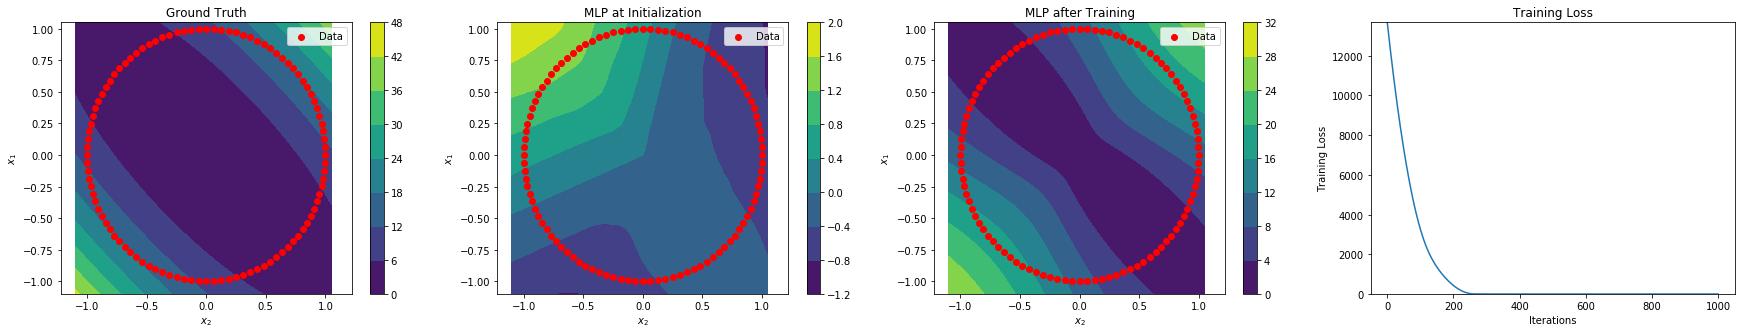

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
True y,10.000000,11.002666,11.989519,12.944996,13.854029,14.702282,15.476377,16.164106,16.754623,17.238616,...,2.391548,2.761384,3.245377,3.835894,4.523623,5.297718,6.145971,7.055004,8.010481,8.997334
Output y,9.997813,11.000576,11.987543,12.943153,13.852321,14.700723,15.474993,16.162904,16.753618,17.237830,...,2.389388,2.759136,3.243062,3.833516,4.521208,5.295291,6.143545,7.052605,8.008121,8.995057


In [2]:
x, true_y, net_y = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=lambda x1, x2: 10 * DataFunc().quadratic(x1, x2, c=0.8),
                                          n_points=100,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

**ICNN with width 10000**:

100%|██████████| 1000/1000 [00:03<00:00, 281.23it/s]


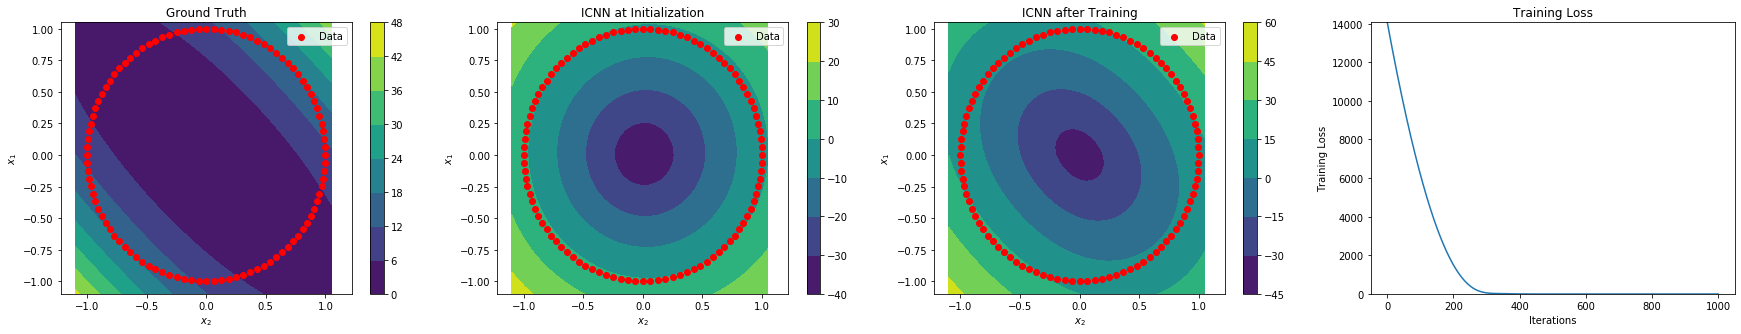

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
True y,10.000000,11.002666,11.989519,12.944996,13.854029,14.702282,15.476377,16.164106,16.754623,17.238616,...,2.391548,2.761384,3.245377,3.835894,4.523623,5.297718,6.145971,7.055004,8.010481,8.997334
Output y,9.999621,11.002312,11.989161,12.944618,13.853671,14.701939,15.476052,16.163800,16.754331,17.238330,...,2.390955,2.760768,3.244756,3.835285,4.523032,5.297155,6.145437,7.054513,8.010034,8.996919


In [3]:
x, true_y, net_y = net_heatmap_comparison(net_arch="icnn",
                                          width=10000,
                                          data_func=lambda x1, x2: 10 * DataFunc().quadratic(x1, x2, c=0.8),
                                          n_points=100,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

### Comparison on Checkerboard Data

Comparison of the ICNN and an MLP fitting the data $\{x_i, y_i\}$ where $x_i \in S^{1}$ and

$$\begin{align*} y_i = \begin{cases}1 & i \text{ odd} \\ -1 & i \text{ even}\end{cases} \end{align*}$$

**MLP with width 10000:**

100%|██████████| 1000/1000 [00:01<00:00, 976.36it/s]


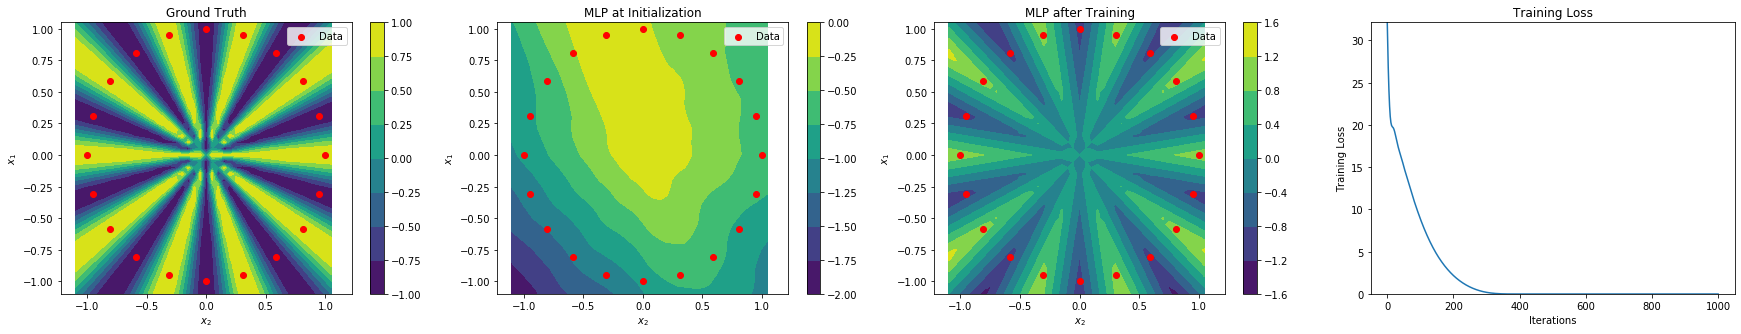

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
True y,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000
Output y,1.002818,-0.998066,1.000592,-1.001009,0.997343,-1.004034,0.994917,-1.005605,0.994385,-1.005072,0.995694,-1.003182,0.997985,-1.000853,1.000248,-0.998665,1.002225,-0.997073,1.003304,-0.996637


In [4]:
x, true_y, net_y = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=lambda x1, x2: DataFunc().checkerboard(x1, x2, n=20),
                                          n_points=20,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

**ICNN with width 10000:**

100%|██████████| 1000/1000 [00:00<00:00, 1112.18it/s]


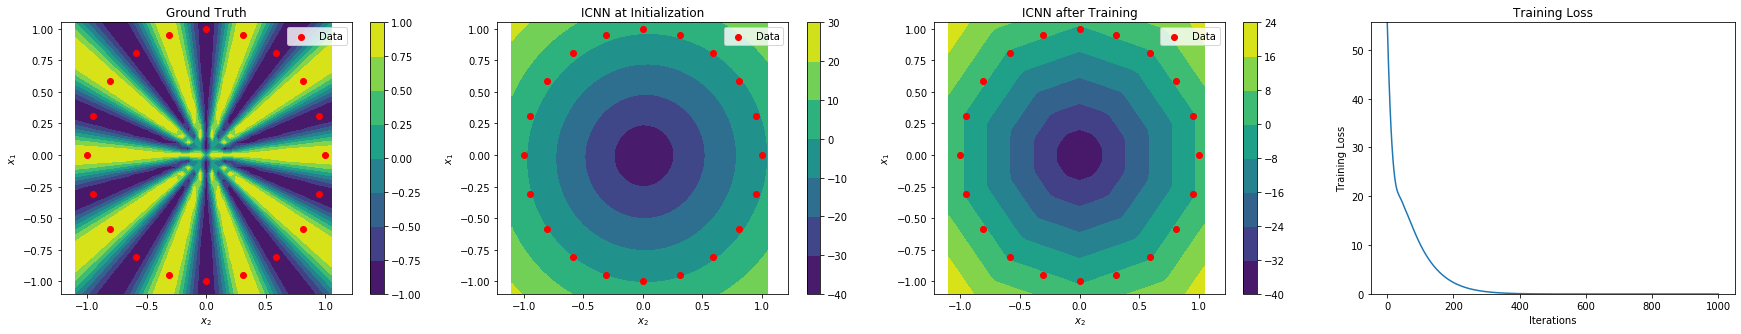

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
True y,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.00000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000
Output y,0.997356,-1.000774,0.997302,-1.000278,0.997667,-1.000252,0.997568,-1.000264,0.99742,-1.000599,0.997905,-1.000006,0.998213,-0.999313,0.998591,-0.999458,0.998153,-0.999945,0.997442,-1.000877


In [5]:
x, true_y, net_y = net_heatmap_comparison(net_arch="icnn",
                                          width=10000,
                                          data_func=lambda x1, x2: DataFunc().checkerboard(x1, x2, n=20),
                                          n_points=20,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

### Comparison on Cliff Data

Comparison of an ICNN and an MLP fitting the data $\{x_i, y_i\}$ where $x_i \in S^{1}$ and

$$\begin{align*} y_i = \begin{cases}1 & x_i^{(2)} > 0 \\ -1 & x_i^{(2)} \leq 0 \end{cases} \end{align*}$$
where $x_i^{(2)} = \langle x_i, e_2 \rangle$ is the up-down coordinate in $\R^2$ of $x_i$. 

**MLP with width 10000:**

100%|██████████| 1000/1000 [00:17<00:00, 58.12it/s]


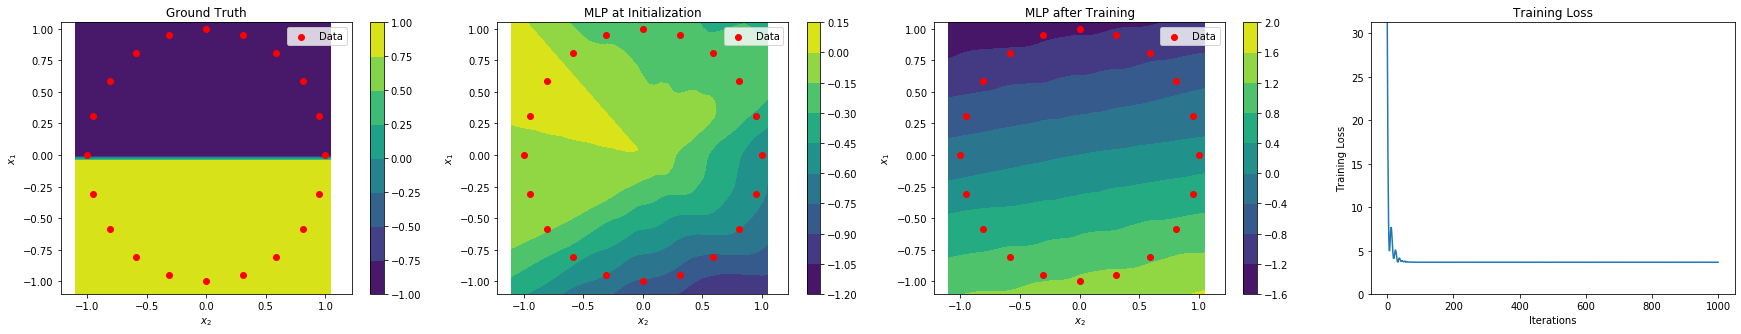

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
True y,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
Output y,0.204478,-0.196242,-0.577976,-0.903436,-1.140813,-1.266899,-1.269376,-1.148004,-0.9146,-0.591905,-0.21141,0.189664,0.571948,0.897944,1.135692,1.26189,1.264162,1.142282,0.908245,0.585067


In [8]:
x, true_y, net_y = net_heatmap_comparison(net_arch="mlp",
                                          width=10000,
                                          data_func=DataFunc().cliff,
                                          n_points=20,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df

**ICNN with width 10000**:

100%|██████████| 1000/1000 [00:00<00:00, 1157.61it/s]


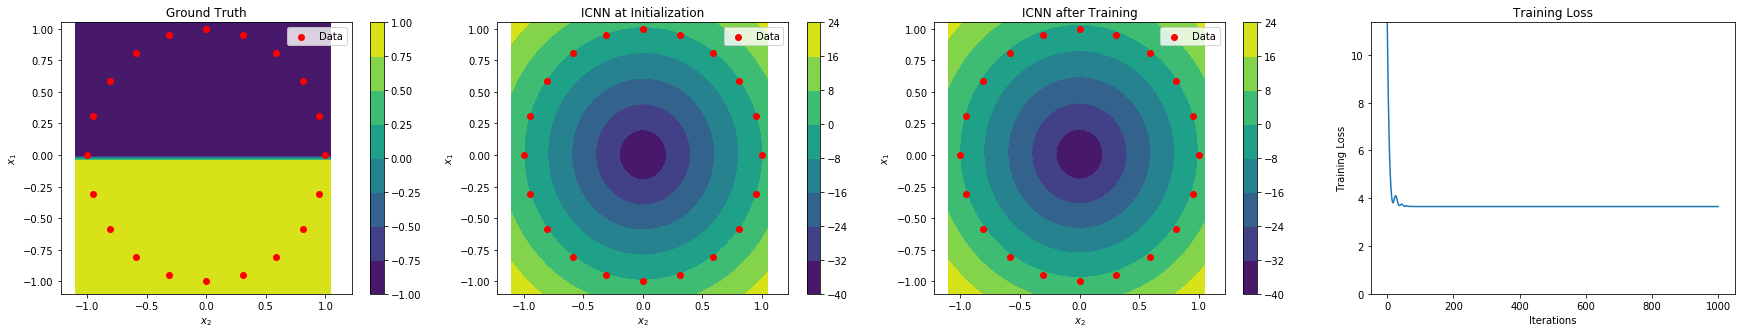

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
True y,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Output y,0.197737,-0.202545,-0.582906,-0.906165,-1.140852,-1.264065,-1.263887,-1.140228,-0.905066,-0.581305,-0.200565,0.199882,0.580857,0.905016,1.140458,1.264062,1.263587,1.139185,0.903162,0.578737


In [7]:
x, true_y, net_y = net_heatmap_comparison(net_arch="icnn",
                                          width=10000,
                                          data_func=DataFunc().cliff,
                                          n_points=20,
                                          sampling_method="regular")

df = pd.DataFrame(np.concatenate((true_y, net_y), axis=-1).T, index=["True y", "Output y"])
df